# Overview

Here we have google share prices with open, high, low , close values for a particular day.
Using this data in our LSTM model we will predict the open prices for next 20 days.

Two files:
1. Training File
2. Test File

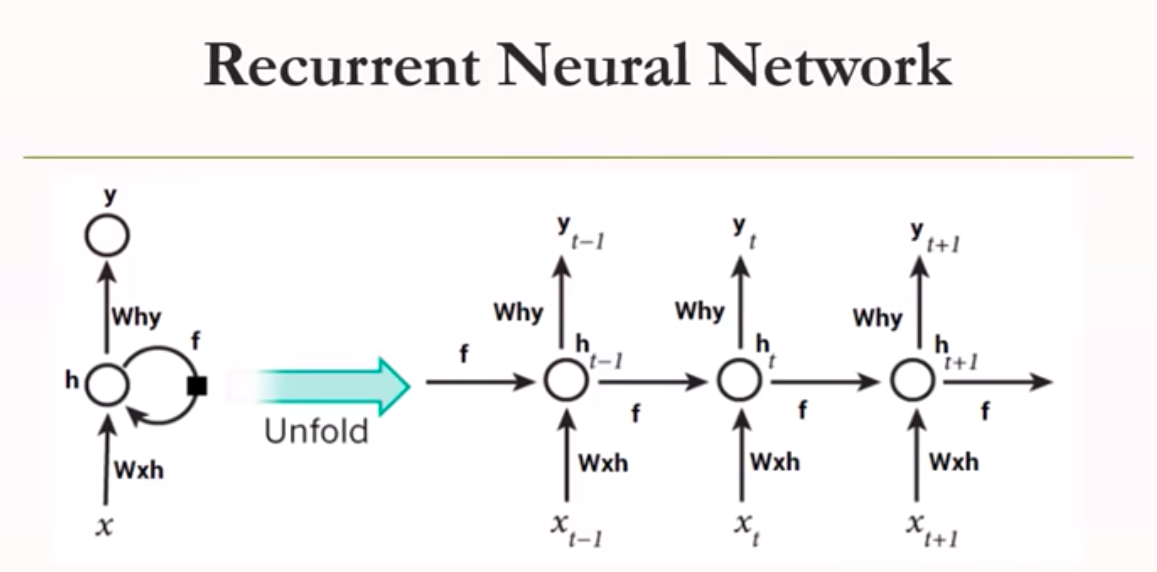

In [12]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [13]:
#Importing the data
train= pd.read_csv('Price_train.csv')
test= pd.read_csv('Price_test.csv')

In [14]:
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [15]:
#taking open price from data in 2d array , if we will do train.loc[:, 'open'].values it gives one d array which wont
#be considered in scaling
train_open= train.iloc[:, 1:2].values


In [16]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [17]:
train_open_scaled[60]

array([0.08627874])

Below we will be taking previous 60 days open datasteps to predict the next values so we are converting the data as per our input in LTSM layers.
i.e for taking 0 to 59 days open price to get 60th day price as output, 1 to 60 for 61, 2 to 61 for 62

In [18]:
# Feature selection
xtrain=[]
ytrain=[]
for i in range(60,len(train_open_scaled)):
    xtrain.append(train_open_scaled[i-60:i,0])
    ytrain.append(train_open_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [19]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [20]:
xtrain.shape

(1198, 60, 1)

### Building the LSTM Network

In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [22]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 40s 234ms/step - loss: 0.0353
Epoch 2/100
40/40 [==============================] - 10s 242ms/step - loss: 0.0066
Epoch 3/100
40/40 [==============================] - 10s 258ms/step - loss: 0.0055
Epoch 4/100
40/40 [==============================] - 9s 223ms/step - loss: 0.0054
Epoch 5/100
40/40 [==============================] - 9s 233ms/step - loss: 0.0050
Epoch 6/100
40/40 [==============================] - 10s 247ms/step - loss: 0.0051
Epoch 7/100
40/40 [==============================] - 9s 224ms/step - loss: 0.0047
Epoch 8/100
40/40 [==============================] - 9s 229ms/step - loss: 0.0046
Epoch 9/100
40/40 [==============================] - 10s 237ms/step - loss: 0.0045
Epoch 10/100
40/40 [==============================] - 9s 220ms/step - loss: 0.0046
Epoch 11/100
40/40 [==============================] - 9s 225ms/step - loss: 0.0040
Epoch 12/100
40/40 [==============================] - 9s 221ms/step - loss: 0.0042
Epoch 13

40/40 [==============================] - 9s 216ms/step - loss: 0.0014
Epoch 100/100
40/40 [==============================] - 9s 216ms/step - loss: 0.0013


### Predicting for test data

As we have 60 input in our layer, we will concatenate our train and test and will take last 60 values of our training set with test set

In [20]:

test_open= test.iloc[:, 1:2].values #taking  open price
total= pd.concat([train['Open'],test['Open']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [21]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction

In [22]:
xtest= np.array(xtest)

In [23]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

1/1 [==============================] - 4s 4s/step


In [24]:
predicted_value= ss.inverse_transform(predicted_value)

### Plotting the data

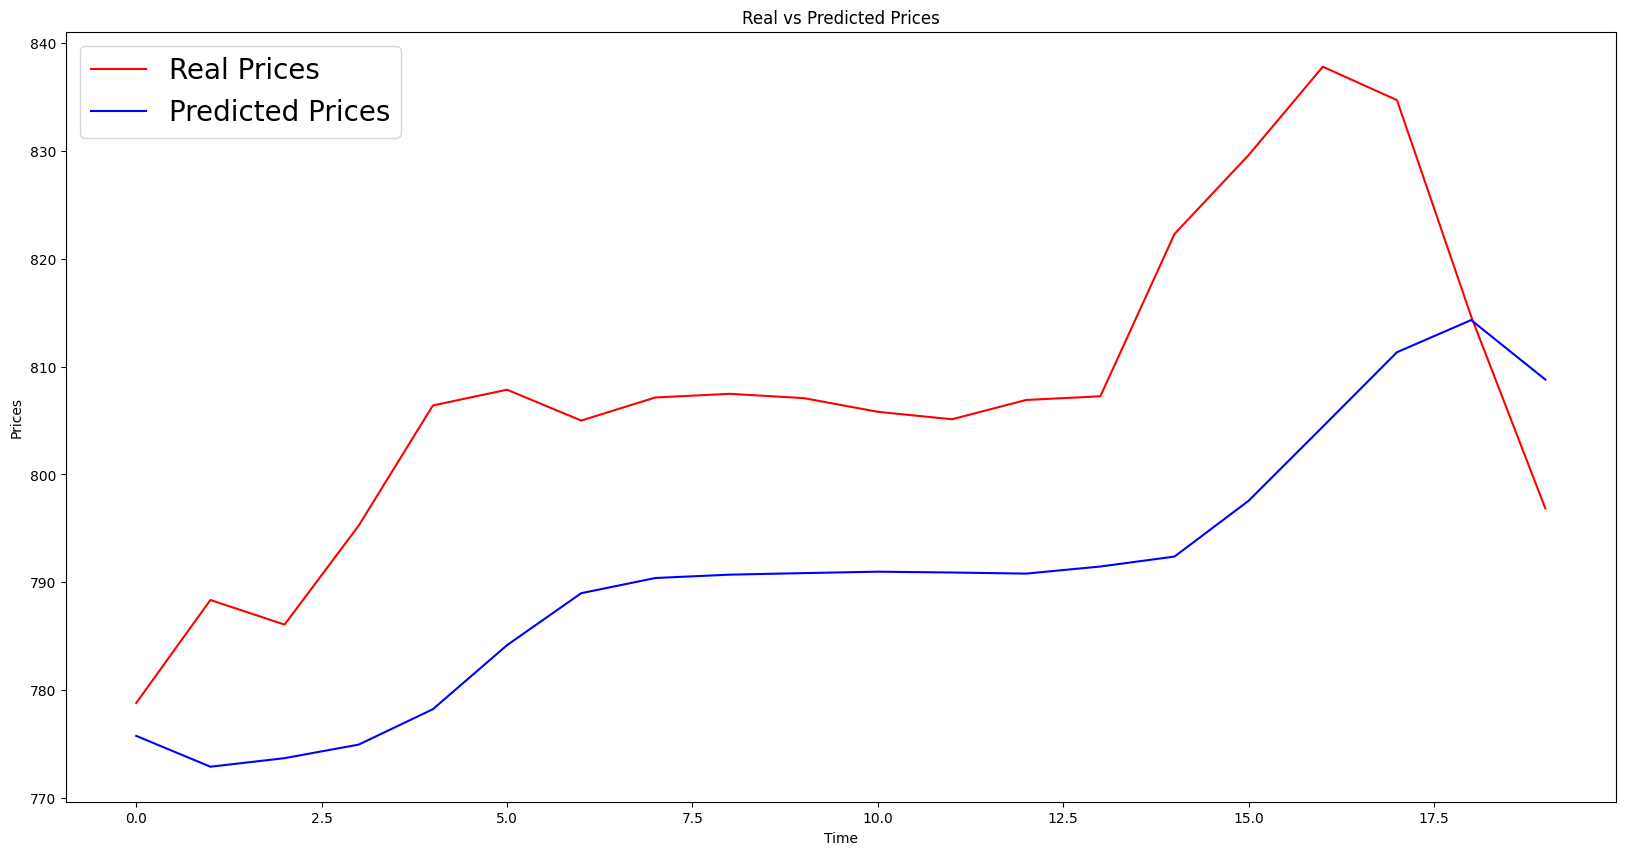

In [25]:
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)


In [26]:
from keras.wrappers.scikit_learn import KerasRegressor

In [27]:
def reg(optimizer):
    #initialisizng the model 
    regression= Sequential()

    #First Input layer and LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
    regression.add(Dropout(0.2))

    # Second LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer= 'glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Third LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
    regression.add(Dropout(0.2))
    #Output layer , we wont pass any activation as its continous value model
    regression.add(Dense(units=1))

    #Compiling the network
    regression.compile(optimizer=optimizer,loss='mean_squared_error')
    
    return regression

model= KerasRegressor(build_fn=reg)

C:\Users\HP\AppData\Local\Temp\ipykernel_9564\2440103601.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model= KerasRegressor(build_fn=reg)


In [28]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'batch_size': [50, 32],
              'epochs': [50, 25],
              'optimizer': ['adam', 'rmsprop','sgd','adadelta']}
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(xtrain, ytrain)
best_parameters = grid_search.best_params_

Epoch 1/50
30/30 [==============================] - 9s 78ms/step - loss: 0.0434
Epoch 2/50
30/30 [==============================] - 2s 77ms/step - loss: 0.0199
Epoch 3/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0137
Epoch 4/50
30/30 [==============================] - 2s 82ms/step - loss: 0.0134
Epoch 5/50
30/30 [==============================] - 2s 80ms/step - loss: 0.0120
Epoch 6/50
30/30 [==============================] - 5s 184ms/step - loss: 0.0121
Epoch 7/50
30/30 [==============================] - 5s 170ms/step - loss: 0.0103
Epoch 8/50
30/30 [==============================] - 4s 149ms/step - loss: 0.0097
Epoch 9/50
30/30 [==============================] - 4s 148ms/step - loss: 0.0100
Epoch 10/50
30/30 [==============================] - 3s 98ms/step - loss: 0.0090
Epoch 11/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0077
Epoch 12/50
30/30 [==============================] - 3s 95ms/step - loss: 0.0078
Epoch 13/50
30/30 [=============

Epoch 50/50
8/8 [==============================] - 3s 40ms/step - loss: 0.0048
Epoch 1/50
30/30 [==============================] - 15s 107ms/step - loss: 0.0275
Epoch 2/50
30/30 [==============================] - 3s 94ms/step - loss: 0.0115
Epoch 3/50
30/30 [==============================] - 3s 102ms/step - loss: 0.0076
Epoch 4/50
30/30 [==============================] - 3s 95ms/step - loss: 0.0078
Epoch 5/50
30/30 [==============================] - 3s 99ms/step - loss: 0.0082
Epoch 6/50
30/30 [==============================] - 3s 90ms/step - loss: 0.0051
Epoch 7/50
30/30 [==============================] - 3s 96ms/step - loss: 0.0068
Epoch 8/50
30/30 [==============================] - 3s 95ms/step - loss: 0.0061
Epoch 9/50
30/30 [==============================] - 3s 97ms/step - loss: 0.0063
Epoch 10/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0047
Epoch 11/50
30/30 [==============================] - 3s 99ms/step - loss: 0.0053
Epoch 12/50
30/30 [=================

20/20 [==============================] - 3s 175ms/step - loss: 0.0075
Epoch 24/25
20/20 [==============================] - 3s 156ms/step - loss: 0.0067
Epoch 25/25
5/5 [==============================] - 2s 65ms/step - loss: 9.2733e-04
Epoch 1/25
20/20 [==============================] - 11s 135ms/step - loss: 0.0413
Epoch 2/25
20/20 [==============================] - 3s 138ms/step - loss: 0.0132
Epoch 3/25
20/20 [==============================] - 3s 130ms/step - loss: 0.0133
Epoch 4/25
20/20 [==============================] - 3s 140ms/step - loss: 0.0117
Epoch 5/25
20/20 [==============================] - 3s 144ms/step - loss: 0.0097
Epoch 6/25
20/20 [==============================] - 3s 128ms/step - loss: 0.0098
Epoch 7/25
20/20 [==============================] - 3s 135ms/step - loss: 0.0098
Epoch 8/25
20/20 [==============================] - 3s 140ms/step - loss: 0.0098
Epoch 9/25
20/20 [==============================] - 3s 128ms/step - loss: 0.0065
Epoch 10/25
20/20 [================

20/20 [==============================] - 4s 198ms/step - loss: 0.4007
Epoch 21/50
20/20 [==============================] - 3s 157ms/step - loss: 0.3974
Epoch 22/50
20/20 [==============================] - 3s 152ms/step - loss: 0.3943
Epoch 23/50
20/20 [==============================] - 3s 157ms/step - loss: 0.3903
Epoch 24/50
20/20 [==============================] - 3s 159ms/step - loss: 0.3871
Epoch 25/50
20/20 [==============================] - 3s 165ms/step - loss: 0.3835
Epoch 26/50
20/20 [==============================] - 3s 159ms/step - loss: 0.3799
Epoch 27/50
20/20 [==============================] - 3s 153ms/step - loss: 0.3765
Epoch 28/50
20/20 [==============================] - 3s 156ms/step - loss: 0.3725
Epoch 29/50
20/20 [==============================] - 3s 152ms/step - loss: 0.3692
Epoch 30/50
20/20 [==============================] - 3s 153ms/step - loss: 0.3654
Epoch 31/50
20/20 [==============================] - 3s 162ms/step - loss: 0.3602
Epoch 32/50
20/20 [=========

20/20 [==============================] - 2s 122ms/step - loss: 0.1971
Epoch 17/50
20/20 [==============================] - 2s 118ms/step - loss: 0.1955
Epoch 18/50
20/20 [==============================] - 2s 117ms/step - loss: 0.1940
Epoch 19/50
20/20 [==============================] - 2s 115ms/step - loss: 0.1921
Epoch 20/50
20/20 [==============================] - 2s 124ms/step - loss: 0.1903
Epoch 21/50
20/20 [==============================] - 2s 116ms/step - loss: 0.1882
Epoch 22/50
20/20 [==============================] - 2s 116ms/step - loss: 0.1870
Epoch 23/50
20/20 [==============================] - 2s 117ms/step - loss: 0.1853
Epoch 24/50
20/20 [==============================] - 2s 119ms/step - loss: 0.1831
Epoch 25/50
20/20 [==============================] - 2s 117ms/step - loss: 0.1808
Epoch 26/50
20/20 [==============================] - 2s 117ms/step - loss: 0.1790
Epoch 27/50
20/20 [==============================] - 2s 115ms/step - loss: 0.1773
Epoch 28/50
20/20 [=========

20/20 [==============================] - 3s 157ms/step - loss: 0.0043
Epoch 13/50
20/20 [==============================] - 4s 184ms/step - loss: 0.0042
Epoch 14/50
20/20 [==============================] - 3s 163ms/step - loss: 0.0040
Epoch 15/50
20/20 [==============================] - 3s 163ms/step - loss: 0.0044
Epoch 16/50
20/20 [==============================] - 3s 163ms/step - loss: 0.0041
Epoch 17/50
20/20 [==============================] - 3s 161ms/step - loss: 0.0036
Epoch 18/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0035
Epoch 19/50
20/20 [==============================] - 3s 163ms/step - loss: 0.0035
Epoch 20/50
20/20 [==============================] - 3s 168ms/step - loss: 0.0036
Epoch 21/50
20/20 [==============================] - 3s 163ms/step - loss: 0.0042
Epoch 22/50
20/20 [==============================] - 3s 174ms/step - loss: 0.0041
Epoch 23/50
20/20 [==============================] - 5s 267ms/step - loss: 0.0039
Epoch 24/50
20/20 [=========

30/30 [==============================] - 3s 115ms/step - loss: 0.2121
Epoch 8/25
30/30 [==============================] - 4s 118ms/step - loss: 0.2091
Epoch 9/25
30/30 [==============================] - 3s 110ms/step - loss: 0.2065
Epoch 10/25
30/30 [==============================] - 4s 117ms/step - loss: 0.2033
Epoch 11/25
30/30 [==============================] - 3s 115ms/step - loss: 0.2011
Epoch 12/25
30/30 [==============================] - 4s 126ms/step - loss: 0.1980
Epoch 13/25
30/30 [==============================] - 4s 126ms/step - loss: 0.1952
Epoch 14/25
30/30 [==============================] - 4s 127ms/step - loss: 0.1921
Epoch 15/25
30/30 [==============================] - 4s 119ms/step - loss: 0.1891
Epoch 16/25
30/30 [==============================] - 5s 183ms/step - loss: 0.1857
Epoch 17/25
30/30 [==============================] - 5s 158ms/step - loss: 0.1839
Epoch 18/25
30/30 [==============================] - 4s 125ms/step - loss: 0.1799
Epoch 19/25
30/30 [===========

In [29]:
model=grid_search.best_estimator_.fit(xtrain,ytrain)

Epoch 1/50
38/38 [==============================] - 18s 219ms/step - loss: 0.0317
Epoch 2/50
38/38 [==============================] - 12s 298ms/step - loss: 0.0129
Epoch 3/50
38/38 [==============================] - 7s 175ms/step - loss: 0.0108
Epoch 4/50
38/38 [==============================] - 10s 246ms/step - loss: 0.0108
Epoch 5/50
38/38 [==============================] - 8s 206ms/step - loss: 0.0090
Epoch 6/50
38/38 [==============================] - 8s 200ms/step - loss: 0.0074
Epoch 7/50
38/38 [==============================] - 9s 246ms/step - loss: 0.0086
Epoch 8/50
38/38 [==============================] - 7s 181ms/step - loss: 0.0071
Epoch 9/50
38/38 [==============================] - 7s 171ms/step - loss: 0.0077
Epoch 10/50
38/38 [==============================] - 7s 173ms/step - loss: 0.0066
Epoch 11/50
38/38 [==============================] - 6s 167ms/step - loss: 0.0066
Epoch 12/50
38/38 [==============================] - 8s 205ms/step - loss: 0.0055
Epoch 13/50
38/38 [===

In [30]:
model

1/1 [==============================] - 3s 3s/step


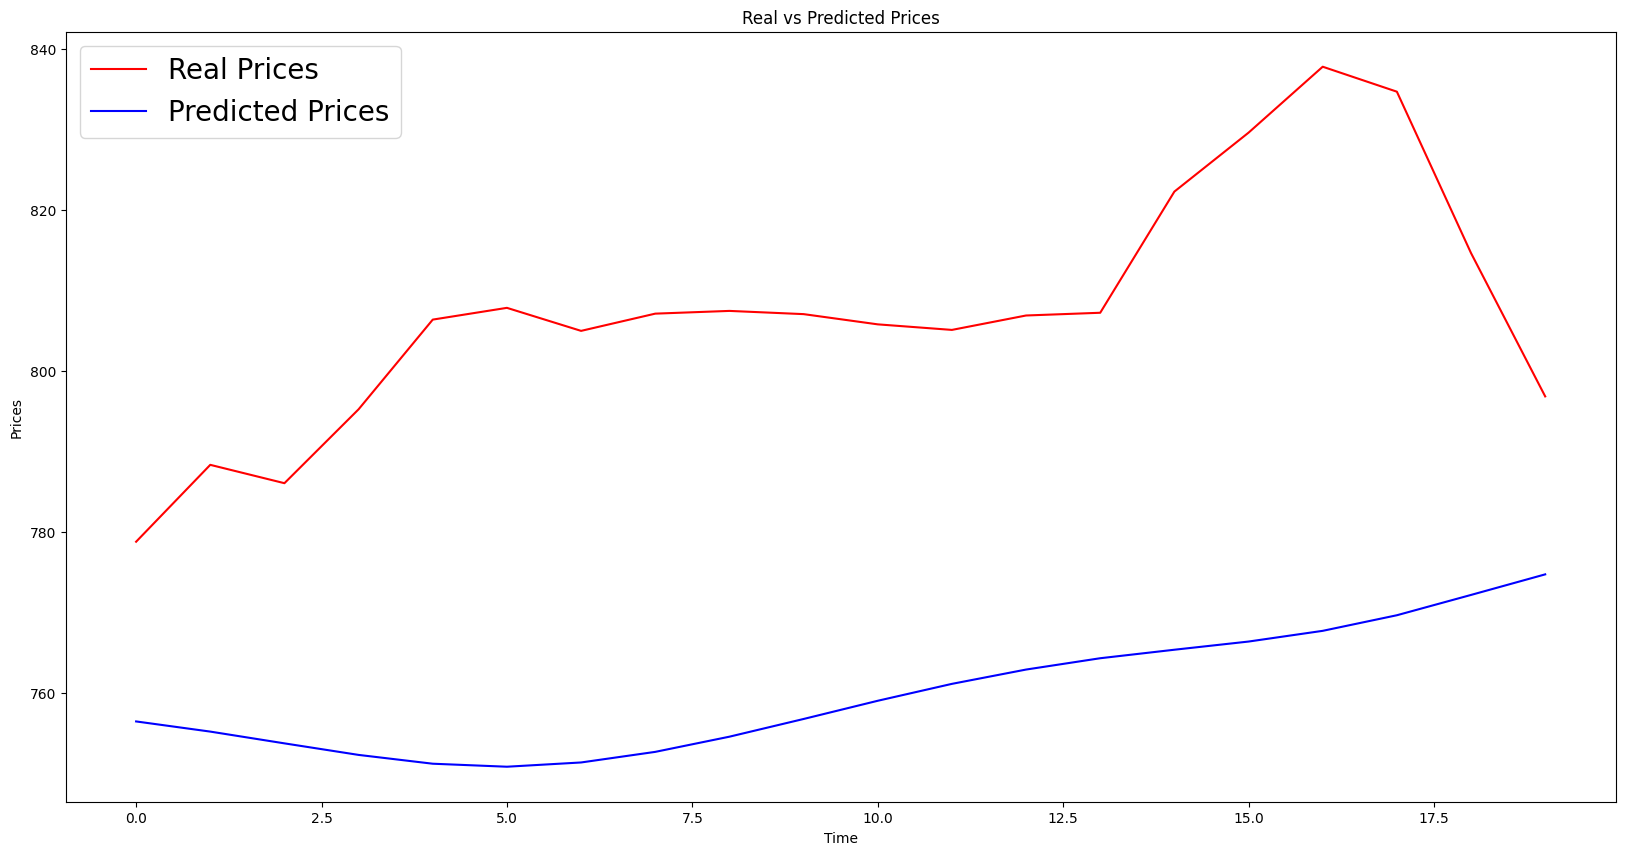

In [31]:
predicted_value= grid_search.predict(xtest)
predicted_value= ss.inverse_transform(predicted_value.reshape(-1,1))


plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)
